In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# format defence and hitpoint experience
def process_df(df):
    exp_type = np.zeros(len(df))
    
    d1 = { "Time (min)" : df["Time (min)"],
           "Exp Gained" : df["Def Exp Gained"],
           "Exp Type"   : exp_type } # initialize exp type column
    defence_df = pd.DataFrame(data = d1)
    defence_df.iloc[:, 2] = "defence" # declare exp type column

    d2 = { "Time (min)" : df["Time (min)"],
           "Exp Gained" : df["HP Exp Gained"],
           "Exp Type"   : exp_type }
    hitpoint_df = pd.DataFrame(data = d2)
    hitpoint_df.iloc[:, 2] = "hitpoint"

    processed_df = defence_df.append(hitpoint_df)

    return processed_df

# return a dataframe containing copies of dataframes 1 and 2 - the Event RPG dataframe must go first
def combine_df(df1, df2):
    df1_copy = df1.copy()
    df2_copy = df2.copy()
    
    df1_copy["Weapon"], df2_copy["Weapon"] = np.zeros(len(df1)), np.zeros(len(df1))
    df1_copy.loc[:, "Weapon"] = "Event RPG"
    df2_copy.loc[:, "Weapon"] = "Iron Scimitar"
    
    combined_df = df1_copy.append(df2_copy)
    
    return combined_df 

def get_regression_inputs(df, weapon):
    section_length = len(combined_df) // 4
    s = np.arange(section_length, 5 * section_length, section_length)
    
    d = {     "Event RPG" : (0, s[0], s[1]),
          "Iron Scimitar" : (s[1], s[2], s[3]) }
    (a, b, c) = d[weapon]
    
    defence_input, hitpoint_input = df.iloc[a:b, 1], df.iloc[b:c, 1]

    return defence_input, hitpoint_input

# linear regression using ordinary least squares 
def linear_regression(x, y):  
    X = np.ones((len(x), 2), np.uint64)
    X[:, 1] = x
    Xt = X.transpose()
    
    # compute beta = (X^t . X)^-1 . X^t . Y
    coefficients = ((np.linalg.inv(Xt.dot(X))).dot(Xt)).dot(y)
    coefficients[0], coefficients[1] = coefficients[1], coefficients[0]
    
    return coefficients

def get_regression_results(time, defence_exp, hitpoint_exp):
    defence_coefficients = linear_regression(time, defence_exp.values)
    defence_linregress_results = stats.linregress(time, defence_exp.values)
    hitpoint_coefficients = linear_regression(time, hitpoint_exp.values)
    hitpoint_linregress_results = stats.linregress(time, hitpoint_exp.values)

    return defence_coefficients, defence_linregress_results, hitpoint_coefficients, hitpoint_linregress_results

def display_results(coefficients, weapon):  
    print("Linear regression results for the", weapon)
    print("Defence Exp")
    print("Slope and x-intercept using matricies:", coefficients[0])
    print("Slope and x-intercept using SciPy stats:", coefficients[1][0:2])
    
    print("\nHitpoint Exp")
    print("Slope and x-intercept using matricies:", coefficients[2])
    print("Slope and x-intercept using SciPy stats:", coefficients[3][0:2])
    
    print("\nThe correlation coefficient is", coefficients[1][2])
    
# calculate the number of hours required to reach final_exp given the initial_exp and coefficients
def get_time(initial_exp, final_exp, coefficients):
    exp_required = final_exp - initial_exp
    
    time = round((exp_required - coefficients[1]) / coefficients[0] / 60)
    
    return time
    
def display_time_required(weapon, time_required):
    print(time_required, "hours are needed to reach level 75 Defence using the", weapon)  

In [3]:
# load preprocessed data
rpg_df = pd.read_csv("data/rpg_data.csv")
scim_df = pd.read_csv("data/scim_data.csv")

In [4]:
# process data
processed_rpg_df = process_df(rpg_df)
processed_scim_df = process_df(scim_df)
combined_df = combine_df(processed_rpg_df, processed_scim_df)

In [5]:
# write processed data to csv
combined_df.to_csv("data/combined_data.csv", index = False)

In [6]:
# load processed data
combined_df = pd.read_csv("data/combined_data.csv")

In [7]:
# get linear regression inputs
time = np.arange(0, 190, 10)

rpg_inputs = get_regression_inputs(combined_df, "Event RPG")
rpg_defence_exp, rpg_hitpoint_exp = rpg_inputs[0], rpg_inputs[1]

scim_inputs = get_regression_inputs(combined_df, "Iron Scimitar")
scim_defence_exp, scim_hitpoint_exp = scim_inputs[0], scim_inputs[1]

In [8]:
# linear regression results for the Event RPG
rpg_results = get_regression_results(time, rpg_defence_exp, rpg_hitpoint_exp)
display_results(rpg_results, "Event RPG")

Linear regression results for the Event RPG
Defence Exp
Slope and x-intercept using matricies: [25.31087719 -3.87368421]
Slope and x-intercept using SciPy stats: (25.310877192982453, -3.873684210526335)

Hitpoint Exp
Slope and x-intercept using matricies: [ 8.41586667 -1.288     ]
Slope and x-intercept using SciPy stats: (8.415866666666666, -1.2879999999998972)

The correlation coefficient is 0.9998153806149918


In [9]:
# linear regression results for the Iron Scimitar
scim_results = get_regression_results(time, scim_defence_exp, scim_hitpoint_exp)
display_results(scim_results, "Iron Scimitar")

Linear regression results for the Iron Scimitar
Defence Exp
Slope and x-intercept using matricies: [21.25333333 18.35789474]
Slope and x-intercept using SciPy stats: (21.253333333333327, 18.35789473684258)

Hitpoint Exp
Slope and x-intercept using matricies: [7.06673333 6.104     ]
Slope and x-intercept using SciPy stats: (7.066733333333333, 6.104000000000042)

The correlation coefficient is 0.9998288328321021


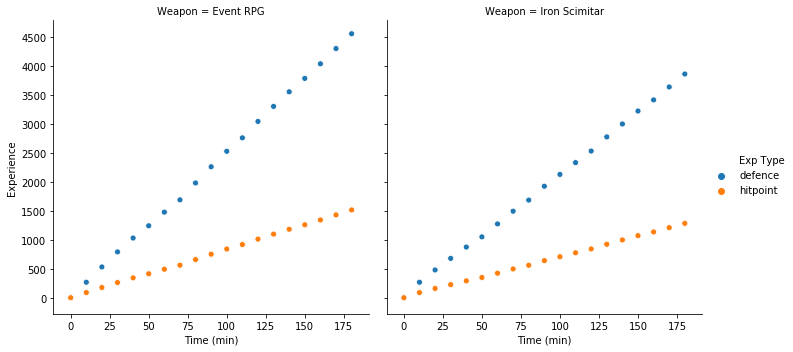

In [10]:
# visualize data
exp_scatter = sns.relplot(x = "Time (min)", 
                          y = "Exp Gained",
                          hue = "Exp Type", 
                          col = "Weapon",
                          data = combined_df)

exp_scatter.set(xlabel = "Time (min)",
                ylabel = "Experience",
                yticks = range(0, 5000, 500))

plt.show()

In [11]:
# extrapolate to obtain the amount of time required to reach level 75 defence (1210421 exp) from 133685 exp
rpg_time_required = get_time(133685, 1210421, rpg_results[0])
display_time_required("Event RPG", rpg_time_required)

scim_time_required = get_time(133685, 1210421, scim_results[0])
display_time_required("Iron Scimitar", scim_time_required)

709.0 hours are needed to reach level 75 Defence using the Event RPG
844.0 hours are needed to reach level 75 Defence using the Iron Scimitar
